In [70]:
import tifffile
from glob import glob
import re
import shutil, os
from tqdm.auto import tqdm
import yaml

In [10]:
all_addrs = glob('/mnt/LSDF/projects/code-vita/Medaka/2018_11/Medaka_*_*/scaled_0.5_8bit_cropped_slices.tif')
good_addrs = [a for a in all_addrs if len(re.findall('Medaka_\d+_\d+-\d+/', a))>0]

In [12]:
random_addrs = good_addrs[:10]

In [20]:
for source_addr in tqdm(random_addrs):
    sample_id = re.findall('Medaka_(\d+)_', source_addr)[0]
    shutil.copy(source_addr, os.path.join('/mnt/LSDF/users/zharov/medakas_segmentation_for_comparison/volumes/', sample_id + '.tif'))

  0%|          | 0/10 [00:00<?, ?it/s]

In [100]:
ls /mnt/LSDF/users/zharov/medakas_segmentation_for_comparison/

DLV3-scratch-0.05/  DLV3-sorting-1.0/  PFPN-simclr-0.1/   PFPN-sorting-1.0/
DLV3-scratch-1.0/   PFPN-scratch-0.1/  PFPN-simclr-1.0/   volumes/
DLV3-sorting-0.05/  PFPN-scratch-1.0/  PFPN-sorting-0.1/


In [69]:
mkdir /mnt/LSDF/users/zharov/medakas_segmentation_for_comparison/PFPN-simclr-1.0

In [97]:
folders = []
for experiment_config_addr in glob('inference_configs/experiment/*.yaml'):
    with open(experiment_config_addr) as f:
        experiment_config = f.readlines()
        folders.append(experiment_config[8][13:-2])

In [114]:
all_experiments = [re.findall('experiment/(.*).yaml', s)[0] for s in glob('inference_configs/experiment/*.yaml')]

In [ ]:
'DLV3-sorting-1.0','PFPN-simclr-1.0','PFPN-sorting-1.0','DLV3-scratch-0.05','DLV3-sorting-0.05','PFPN-simclr-0.1','PFPN-scratch-1.0','PFPN-sorting-0.1','DLV3-scratch-1.0','PFPN-scratch-0.1'

In [86]:
experiment_config_addr

'inference_configs/experiment/PFPN-scratch-0.1.yaml'

In [46]:
ls /mnt/LSDF/users/zharov/medakas_segmentation_for_comparison/volumes/

512.tif  527.tif  548.tif  596.tif  691.tif
522.tif  537.tif  591.tif  602.tif  723.tif


In [50]:
ls /mnt/LSDF/users/zharov/medakas_segmentation_for_comparison/PFPN-scratch-1.0

pfpn_scratch_10_512.tif  pfpn_scratch_10_548.tif  pfpn_scratch_10_691.tif
pfpn_scratch_10_522.tif  pfpn_scratch_10_591.tif  pfpn_scratch_10_723.tif
pfpn_scratch_10_527.tif  pfpn_scratch_10_596.tif
pfpn_scratch_10_537.tif  pfpn_scratch_10_602.tif


In [45]:
mv /mnt/LSDF/users/zharov/medakas_segmentation_for_comparison/volumes/pfpn_scratch_10_* /mnt/LSDF/users/zharov/medakas_segmentation_for_comparison/PFPN-scratch-1.0

In [33]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

In [126]:
from albumentations import CropNonEmptyMaskIfExists, PadIfNeeded, Compose

In [172]:
size = 256
aug = Compose([PadIfNeeded(size, size, border_mode=0), CropNonEmptyMaskIfExists(size, size, always_apply=True)],
              additional_targets={'mask2': 'mask','mask3': 'mask'})

In [194]:
aqaq = list((0, 1 ,2))

In [195]:
aqaq.pop(1), aqaq

(1, [0, 2])

In [196]:
from skimage.measure import label
def select_top_k_connected_areas(markup, k):
    connected_regions = label(markup)
    region_id, region_size = np.unique(connected_regions, return_counts=True)
    regions_order = (np.argsort(region_size[1:]) + 1)[::-1] # ordering without zero
    return np.isin(connected_regions, regions_order[:k])

def _get_bbox_1D(markup, pct=None):
    axes = []
    for ax in [0, 1, 2]:
        all_axes = list((0, 1 ,2))
        all_axes.pop(ax)
        sum_along = markup.sum(tuple(all_axes))
        thr = 0 if pct is None else np.percentile(sum_along, pct)
        axes.append(sum_along > thr)

    axes = [select_top_k_connected_areas(ax, 2) for ax in axes]

    axes = [np.where(ax)[0] for ax in axes]
    if min([len(ax) for ax in axes]) == 0:
        raise CleanerError('bounding box cleaner', 'bounding box is empty')
        
    return [(ax[0], ax[-1]) for ax in axes]

roi_to_slices = lambda roi: tuple([slice(*i) for i in roi])

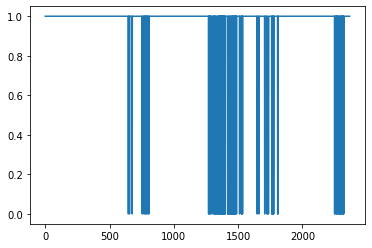

In [184]:
plt.plot(msks[0].sum((1,2)) > 0)

In [169]:
ids = [512, 527, 548, 596, 691, 522, 537, 591, 602, 723]

In [245]:
id = ids[1]
versions = ['PFPN-sorting-1.0', 'PFPN-simclr-1.0', 'PFPN-scratch-1.0'] 
# versions = ['PFPN-sorting-0.1', 'PFPN-simclr-0.1', 'PFPN-scratch-0.1']
# versions = ['DLV3-sorting-1.0', 'DLV3-scratch-1.0']
# versions = ['DLV3-sorting-0.05', 'DLV3-scratch-0.05']

img = tifffile.imread(f'/mnt/LSDF/users/zharov/medakas_segmentation_for_comparison/volumes/{id}.tif')
msks = [tifffile.imread(f'/mnt/LSDF/users/zharov/medakas_segmentation_for_comparison/{v}/{id}.tif') for v in versions]

bb = _get_bbox_1D(msks[0], 5)
simg = img[roi_to_slices(bb)]
smsks = [m[roi_to_slices(bb)] for m in msks]


In [246]:
ref_mask = (smsks[0] == 3)
poses = [np.argmax(ref_mask.sum((1,2))), np.argmax(ref_mask.sum((0,2))), np.argmax(ref_mask.sum((0,1)))]

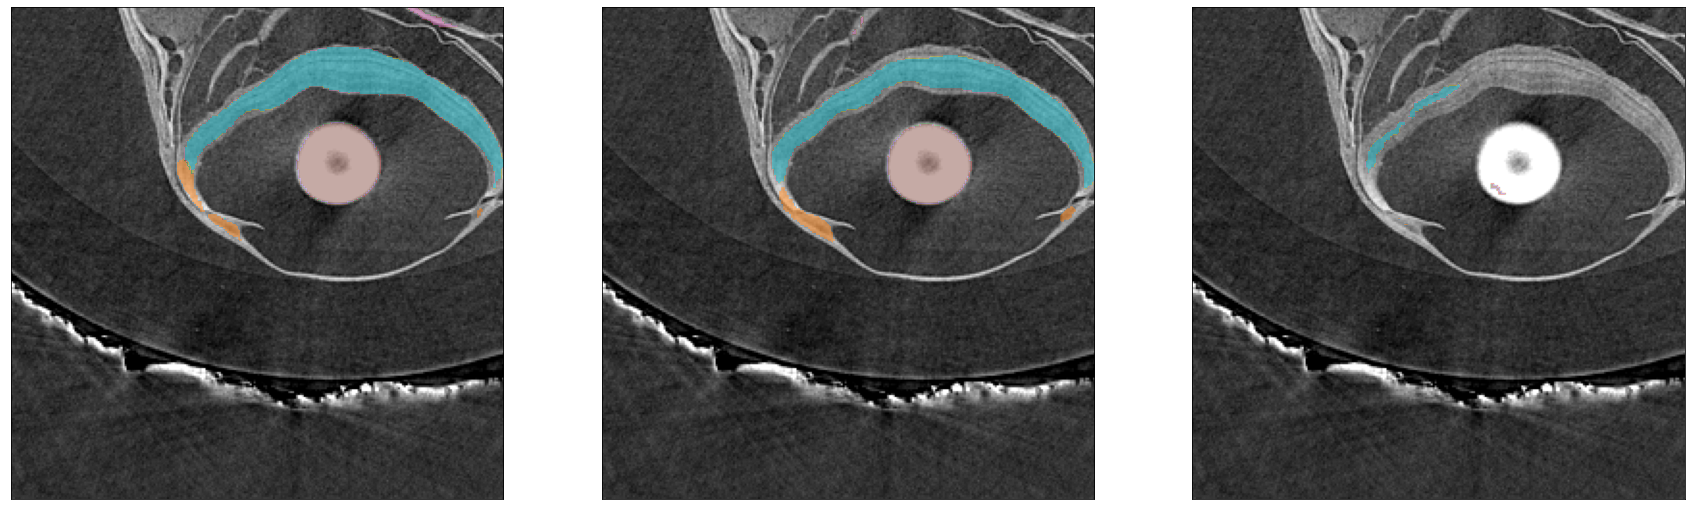

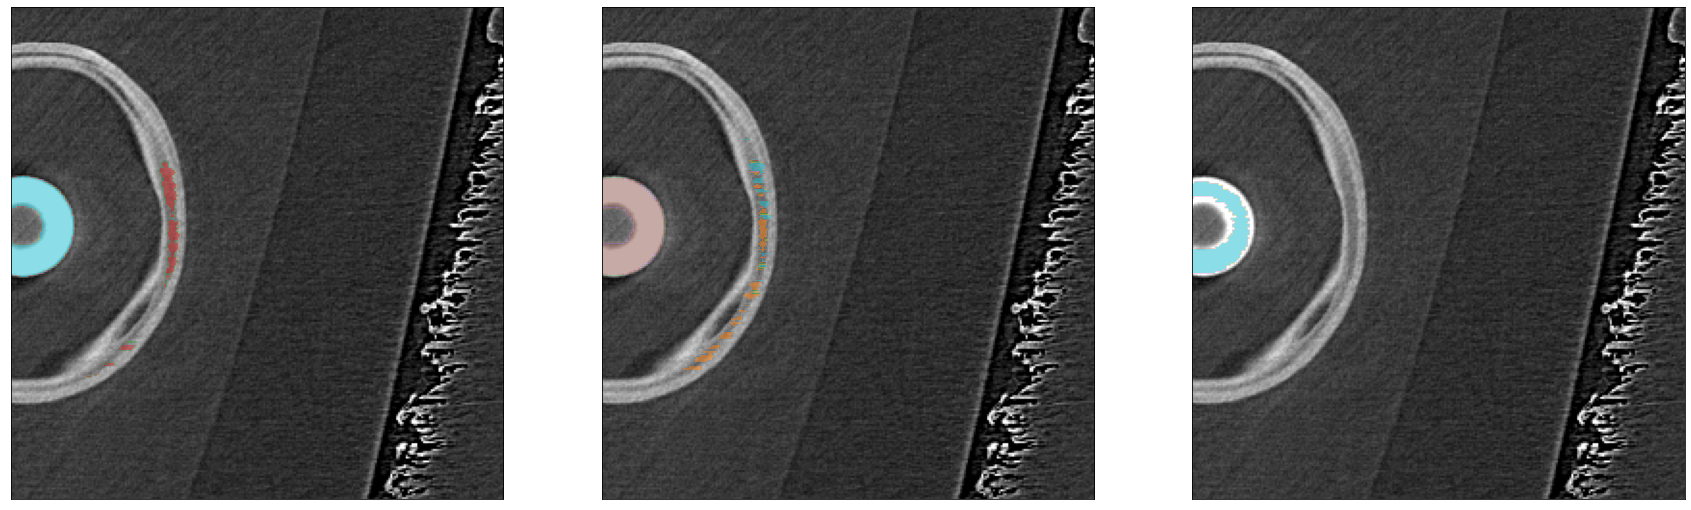

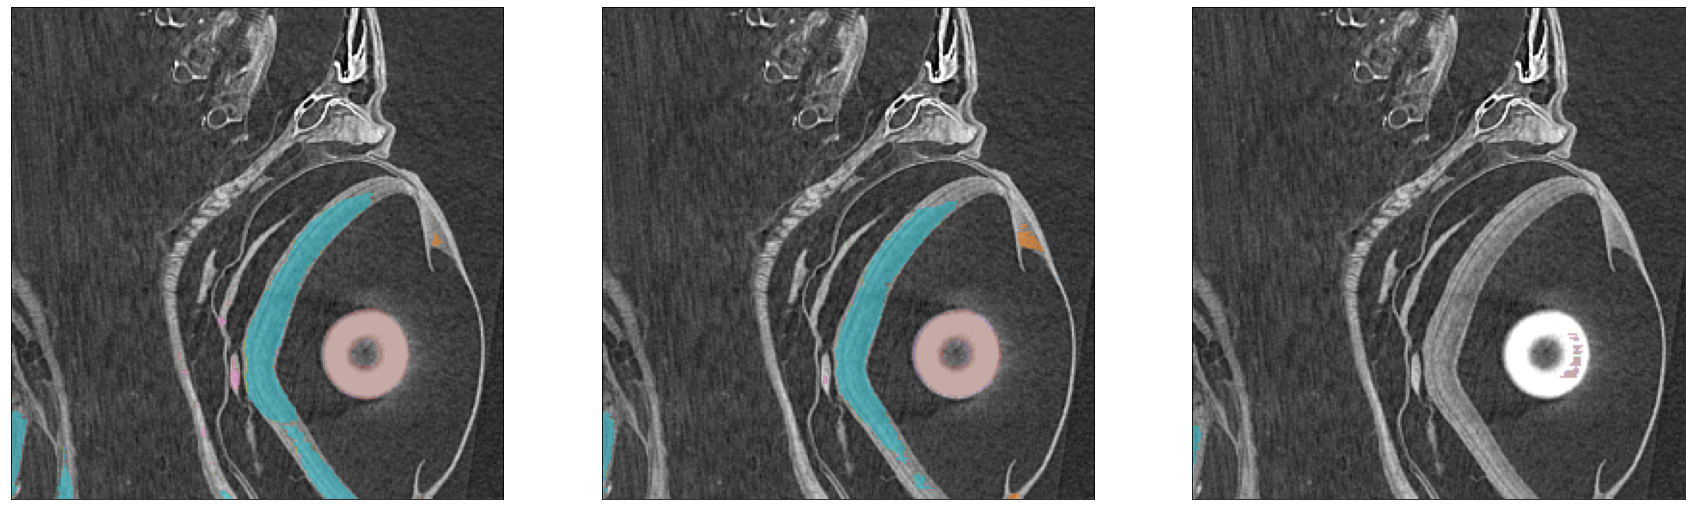

In [247]:
for axis, pos in enumerate(poses):
    
    subimg = simg.take(pos, axis)
    submasks = [s.take(pos, axis) for s in smsks]
    fig, axes = plt.subplots(ncols=len(submasks), figsize=(10*len(submasks), 10))

    if len(submasks) == 3:
        cropt = aug(image=subimg, mask=submasks[0], mask2=submasks[1], mask3=submasks[2])
        subimg = cropt["image"]
        submasks = [cropt["mask"], cropt["mask2"], cropt["mask3"]]
    elif len(submasks) == 2:
        cropt = aug(image=subimg, mask=submasks[0], mask2=submasks[1])
        subimg = cropt["image"]
        submasks = [cropt["mask"], cropt["mask2"]]
        
    
    for submask, ax in zip(submasks, axes):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(subimg, cmap='gray')
        ax.imshow(submask, cmap='tab10', alpha=(submask>0)*0.5)
    plt.show()


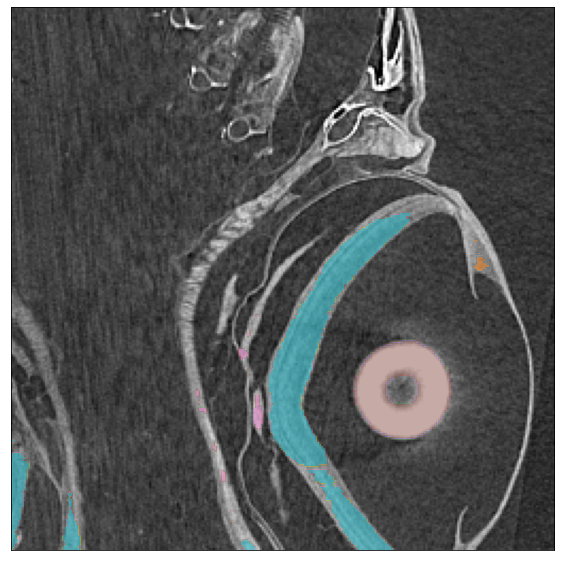

In [251]:
plt.figure(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(subimg, cmap='gray')
plt.imshow(submasks[0], cmap='tab10', alpha=(submasks[0]>0)*0.5)
plt.show()